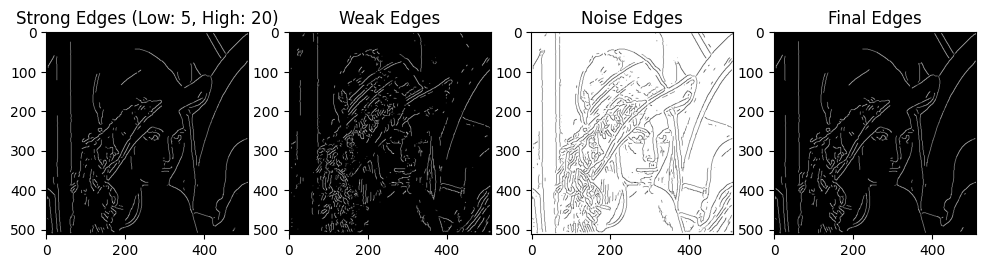

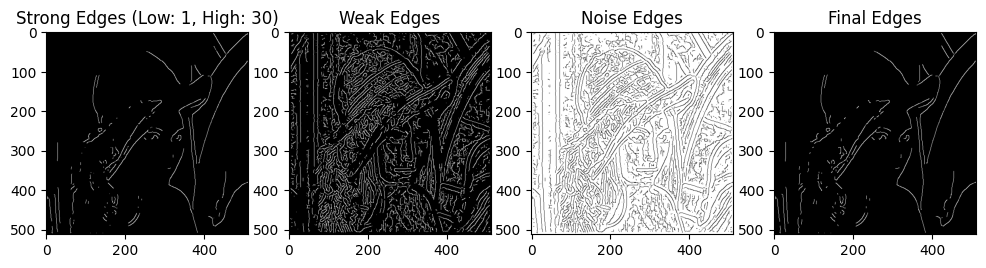

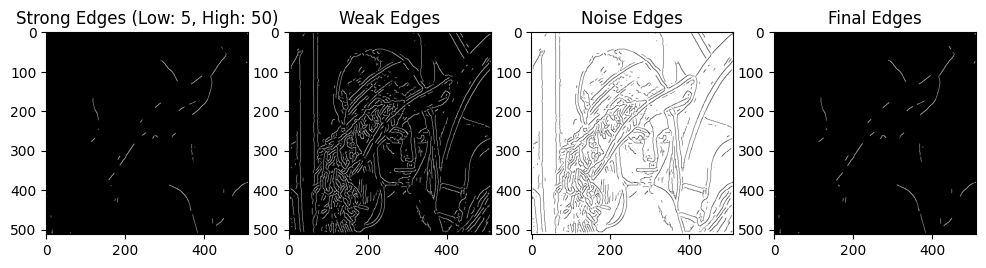

In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

def convolution(im, kernel):
    kernel = np.flip(np.flip(kernel, axis=0), axis=1)
    im_height, im_width = im.shape
    kernel_size = kernel.shape[0]
    pad_size = int((kernel_size - 1) / 2)
    im_padded = np.zeros((im_height + pad_size * 2, im_width + pad_size * 2))
    im_padded[pad_size:-pad_size, pad_size:-pad_size] = im

    im_out = np.zeros_like(im)
    for x in range(im_width):
        for y in range(im_height):
            im_patch = im_padded[y:y + kernel_size, x:x + kernel_size]
            new_value = np.sum(kernel * im_patch)
            im_out[y, x] = new_value
    return im_out

def get_gaussian_kernel(kernel_size, sigma):
    kernel_x = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    for i in range(kernel_size):
        kernel_x[i] = np.exp(-(kernel_x[i] / sigma) ** 2 / 2)
    kernel = np.outer(kernel_x.T, kernel_x.T)
    kernel *= 1.0 / kernel.sum()
    return kernel

def compute_gradient(im):
    sobel_filter_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_filter_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gradient_x = convolution(im, sobel_filter_x)
    gradient_y = convolution(im, sobel_filter_y)

    magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    magnitude *= 255.0 / magnitude.max()
    direction = np.arctan2(gradient_y, gradient_x)
    direction = np.degrees(direction) % 180
    return magnitude, direction

def nms(magnitude, direction):
    height, width = magnitude.shape
    res = np.zeros(magnitude.shape)
    direction[direction < 0] += 180

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            current_direction = direction[y, x]
            current_magnitude = magnitude[y, x]

            if (0 <= current_direction < 22.5) or (157.5 <= current_direction < 180):
                p = magnitude[y, x - 1]
                r = magnitude[y, x + 1]
            elif 22.5 <= current_direction < 67.5:
                p = magnitude[y + 1, x + 1]
                r = magnitude[y - 1, x - 1]
            elif 67.5 <= current_direction < 112.5:
                p = magnitude[y - 1, x]
                r = magnitude[y + 1, x]
            else:
                p = magnitude[y - 1, x + 1]
                r = magnitude[y + 1, x - 1]

            if current_magnitude >= p and current_magnitude >= r:
                res[y, x] = current_magnitude

    return res

def hysteresis_thresholding(magnitude, low_threshold, high_threshold):
    strong_edges = np.zeros_like(magnitude, dtype=np.uint8)
    weak_edges = np.zeros_like(magnitude, dtype=np.uint8)
    noise_edges = np.zeros_like(magnitude, dtype=np.uint8)

    strong_edges[magnitude >= high_threshold] = 255
    weak_edges[(magnitude >= low_threshold) & (magnitude < high_threshold)] = 255
    noise_edges[magnitude < low_threshold] = 255

    return strong_edges, weak_edges, noise_edges

def edge_linking(strong_edges, weak_edges):
    height, width = strong_edges.shape
    output = np.zeros_like(strong_edges)

    for y in range(height):
        for x in range(width):
            if strong_edges[y, x] == 255:
                output[y, x] = 255
            elif weak_edges[y, x] == 255:
                if ((x > 0 and strong_edges[y, x - 1] == 255) or
                    (x < width - 1 and strong_edges[y, x + 1] == 255) or
                    (y > 0 and strong_edges[y - 1, x] == 255) or
                    (y < height - 1 and strong_edges[y + 1, x] == 255) or
                    (x > 0 and y > 0 and strong_edges[y - 1, x - 1] == 255) or
                    (x < width - 1 and y > 0 and strong_edges[y - 1, x + 1] == 255) or
                    (x > 0 and y < height - 1 and strong_edges[y + 1, x - 1] == 255) or
                    (x < width - 1 and y < height - 1 and strong_edges[y + 1, x + 1] == 255)):
                    output[y, x] = 255

    return output

im = cv2.imread("lena.png", 0)
im = im.astype(float)

gaussian_kernel = get_gaussian_kernel(9, 3)
im_smoothed = convolution(im, gaussian_kernel)

gradient_magnitude, gradient_direction = compute_gradient(im_smoothed)

nms_magnitude = nms(gradient_magnitude, gradient_direction)

thresholds = [(5, 20), (1, 30), (5, 50)]
for low_threshold, high_threshold in thresholds:
    strong_edges, weak_edges, noise_edges = hysteresis_thresholding(nms_magnitude, low_threshold, high_threshold)

    final_edges = edge_linking(strong_edges, weak_edges)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 4, 1)
    plt.title(f'Strong Edges (Low: {low_threshold}, High: {high_threshold})')
    plt.imshow(strong_edges, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('Weak Edges')
    plt.imshow(weak_edges, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Noise Edges')
    plt.imshow(noise_edges, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title('Final Edges')
    plt.imshow(final_edges, cmap='gray')

    plt.show()

    cv2.imwrite(f'strong_edges_low{low_threshold}_high{high_threshold}.png', strong_edges)
    cv2.imwrite(f'weak_edges_low{low_threshold}_high{high_threshold}.png', weak_edges)
    cv2.imwrite(f'noise_edges_low{low_threshold}_high{high_threshold}.png', noise_edges)
    cv2.imwrite(f'final_edges_low{low_threshold}_high{high_threshold}.png', final_edges)


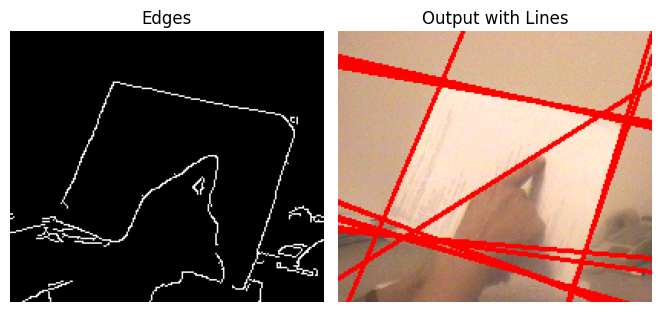

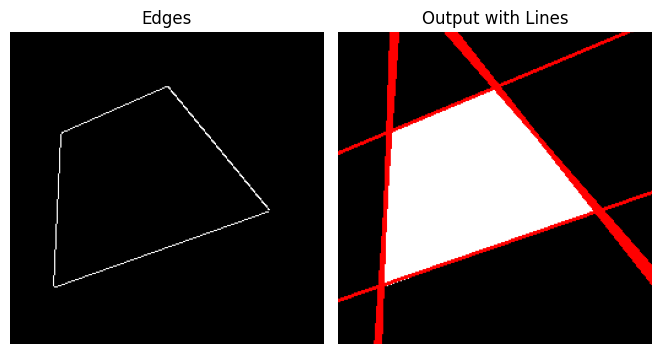

In [2]:
def HoughTransform(edge_map):
    theta_values = np.deg2rad(np.arange(-90.0, 90.0))
    height, width = edge_map.shape
    diagonal_length = int(round(math.sqrt(width * width + height * height)))
    rho_values = np.linspace(-diagonal_length, diagonal_length, diagonal_length * 2 + 1)

    accumulator = np.zeros((len(rho_values), len(theta_values)), dtype=int)
    y_coordinates, x_coordinates = np.nonzero(edge_map)

    for edge_idx in range(len(x_coordinates)):
        x = x_coordinates[edge_idx]
        y = y_coordinates[edge_idx]
        for theta_idx in range(len(theta_values)):
            theta = theta_values[theta_idx]
            rho = int(round(x * np.cos(theta) + y * np.sin(theta)))
            accumulator[rho + diagonal_length, theta_idx] += 1

    return accumulator, theta_values, rho_values

def non_maximum_suppression(accumulator, threshold=30):
    suppressed = np.zeros_like(accumulator)
    indices = np.argwhere(accumulator > threshold)

    for idx in indices:
        rho_idx, theta_idx = idx
        value = accumulator[rho_idx, theta_idx]
        if np.all(value >= accumulator[rho_idx - 1:rho_idx + 2, theta_idx - 1:theta_idx + 2]):
            suppressed[rho_idx, theta_idx] = value

    return suppressed

def draw_lines(im, lines, rho_values, theta_values):
    height, width = im.shape[:2]
    for line in lines:
        rho = rho_values[line[0]]
        theta = theta_values[line[1]]
        slope = -np.cos(theta) / np.sin(theta)
        intercept = rho / np.sin(theta)
        x1, x2 = 0, width
        y1 = int(slope * x1 + intercept)
        y2 = int(slope * x2 + intercept)
        cv2.line(im, (x1, y1), (x2, y2), (0, 0, 255), 2)

for image_path in ['paper.bmp', 'shape.bmp']:
    im = cv2.imread(image_path)
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    edge_map = cv2.Canny(im_gray, 70, 150)
    accumulator, theta_values, rho_values = HoughTransform(edge_map)
    suppressed_accumulator = non_maximum_suppression(accumulator)
    lines = np.argwhere(suppressed_accumulator > 40)
    draw_lines(im, lines, rho_values, theta_values)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(edge_map, cmap='gray')
    plt.title('Edges')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title('Output with Lines')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    edge_map_filename = f"{image_path.split('.')[0]}_edge_map.png"
    output_with_lines_filename = f"{image_path.split('.')[0]}_output_lines.png"
    cv2.imwrite(edge_map_filename, edge_map)
    cv2.imwrite(output_with_lines_filename, cv2.cvtColor(im, cv2.COLOR_BGR2RGB))


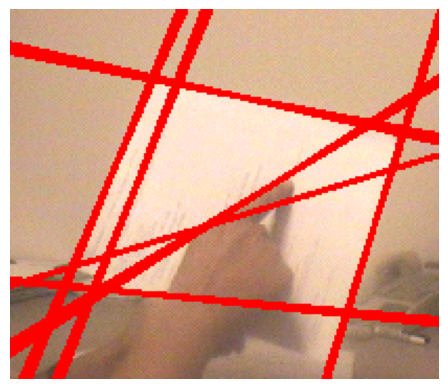

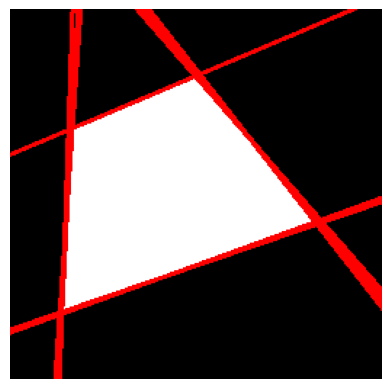

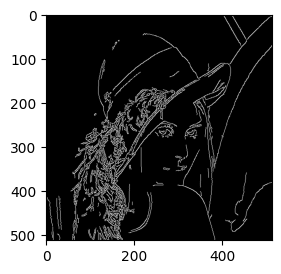

In [4]:
def detect_lines(image_path, edge_threshold1, edge_threshold2, hough_rho, hough_theta, hough_threshold):
    img = cv2.imread(image_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, edge_threshold1, edge_threshold2)

    lines = cv2.HoughLines(edges, hough_rho, hough_theta, hough_threshold)

    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)


    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    filename = f"{image_path.split('.')[0]}_edges_p4.png"

    cv2.imwrite(filename, img_rgb)

detect_lines('/content/paper.bmp', 30, 100, 1, np.pi / 180, 53)
detect_lines('/content/shape.bmp', 30, 100, 1, np.pi / 180, 40)
img = cv2.imread('/content/lena.png', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img, 100, 200)
cv2.imwrite("lena_edges_p4.png", edges)
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.show()
